In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
import datetime as dt
import pickle
import tensorflow
import joblib

In [24]:
drivers_data=pd.read_csv('/content/dataset/drivers_preprocessed.csv')
constructors_data=pd.read_csv('/content/dataset/constructors_preprocessed.csv')
race_data=pd.read_csv('/content/dataset/races_preprocessed.csv')
results_data=pd.read_csv('/content/dataset/results_preprocessed.csv')
status_data=pd.read_csv('/content/dataset/status_preprocessed.csv')

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1 MODEL - MULTI LINEAR REGRESSION

In [ ]:
driver_encoder = LabelEncoder()
results_data['driver_encoded'] = driver_encoder.fit_transform(results_data['driverId'])

constructor_encoder = LabelEncoder()
results_data['constructor_encoded'] = constructor_encoder.fit_transform(results_data['constructorId'])


In [ ]:
results_data = results_data.merge(race_data[['raceId', 'year']], on='raceId', how='left')
driver_stats = results_data.groupby(['driverId', 'year']).agg({
    'points': 'sum',
    'positionOrder': 'mean',
    'raceId': 'count'
}).reset_index()

driver_stats.rename(columns={
    'positionOrder': 'avg_finish',
    'raceId': 'num_races'
}, inplace=True)

Driver Points Prediction MSE: 1415.98
Predicted Drivers' Champion for 2025: Driver ID 830.0 with 77.3 points
Predicted Constructors' Champion for 2025: Constructor ID 1.0 with 34118.2 points


<ipython-input-21-b66ba201deb0>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_season['predicted_points_2025'] = future_points


In [ ]:
X = driver_stats[['avg_finish', 'num_races']]
y = driver_stats['points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Driver Points Prediction MSE: {mse:.2f}")

Driver Points Prediction MSE: 1415.98


In [ ]:
# Predict for next year
recent_season = driver_stats[driver_stats['year'] == driver_stats['year'].max()]
X_future = recent_season[['avg_finish', 'num_races']]
future_points = model.predict(X_future)

recent_season['predicted_points_2025'] = future_points

# Determine predicted Drivers' Champion
driver_champion = recent_season.loc[recent_season['predicted_points_2025'].idxmax()]
print(f"Predicted Drivers' Champion for 2025: Driver ID {driver_champion['driverId']} with {driver_champion['predicted_points_2025']:.1f} points")


Predicted Drivers' Champion for 2025: Driver ID 830.0 with 77.3 points


<ipython-input-23-4ad62badd85a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_season['predicted_points_2025'] = future_points


In [ ]:
results_with_constructor = results_data.merge(recent_season[['driverId', 'predicted_points_2025']], on='driverId', how='left')
constructor_points = results_with_constructor.groupby('constructorId')['predicted_points_2025'].sum().reset_index()

# Determine predicted Constructors' Champion
constructor_champion = constructor_points.loc[constructor_points['predicted_points_2025'].idxmax()]
print(f"Predicted Constructors' Champion for 2025: Constructor ID {constructor_champion['constructorId']} with {constructor_champion['predicted_points_2025']:.1f} points")


Predicted Constructors' Champion for 2025: Constructor ID 1.0 with 34118.2 points


#2. MODEL-XGBOOST



In [5]:
def prepare_input_data(race_data, results_data, drivers_data, constructors_data, status_data):

    race_data.rename(columns={'name': 'event', 'date': 'EventDate'}, inplace=True)
    merged_data = results_data.merge(race_data[['raceId', 'year', 'event', 'EventDate']], on='raceId', how='left')

    drivers_data['FullName']=drivers_data['forename']+" "+drivers_data['surname']
    merged_data = merged_data.merge(drivers_data[['driverId', 'FullName', 'nationality']], on='driverId', how='left')

    constructors_data.rename(columns={'name': 'TeamName'}, inplace=True)
    merged_data = merged_data.merge(constructors_data[['constructorId', 'TeamName', 'nationality']], on='constructorId', how='left')
    merged_data = merged_data.merge(status_data[['statusId', 'status']], on='statusId', how='left')

    # Feature Engineering
    merged_data['Status_Finished'] = merged_data['status'].apply(lambda x: 1 if 'Finished' in str(x) else 0)
    merged_data['is_podium'] = merged_data['positionOrder'].apply(lambda x: 1 if x in [1, 2, 3] else 0)
    merged_data['is_first'] = merged_data['positionOrder'].apply(lambda x: 1 if x == 1 else 0)
    merged_data['is_top_two'] = merged_data['positionOrder'].apply(lambda x: 1 if x in [1, 2] else 0)
    merged_data['is_winner'] = merged_data['positionOrder'].apply(lambda x: 1 if x == 1 else 0)

    # Handling missing values
    merged_data.fillna(0, inplace=True)
    return merged_data


In [6]:
def prepare_data(df, target_col, drop_cols):
    df = df.dropna(subset=[target_col])
    X = df.drop(drop_cols + [target_col], axis=1)
    y = df[target_col]
    return X, y

In [7]:
def train_xgb_model(X, y):
    scaler = StandardScaler()
    over_sampler = RandomOverSampler(random_state=42)
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('over_sampler', over_sampler),
        ('xgb', xgb)
    ])

    param_grid = {
        'xgb__max_depth': [3, 5, 7],
        'xgb__n_estimators': [100, 200, 300],
        'xgb__learning_rate': [0.01, 0.05, 0.1],
        'xgb__subsample': [0.8, 1],
        'xgb__colsample_bytree': [0.8, 1]
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)

    print("Best Parameters:", grid_search.best_params_)
    print("Best CV Score:", grid_search.best_score_)
    return grid_search.best_estimator_

In [8]:
def predict_championship(model, df, season_year):

    df_season = df[df['year'] == season_year].copy()
    feature_cols = [col for col in df_season.columns if col not in ['year', 'driverId', 'constructorId']]
    X_season = df_season[feature_cols]

    # Make predictions
    predictions = model.predict(X_season)
    df_season.loc[:, 'Predicted_Position'] = predictions


    driver_champ = df_season[df_season['Predicted_Position'] == 1]['driverId'].mode()[0]

    constructor_points = df_season.groupby('constructorId')['Predicted_Position'].apply(lambda x: (x == 1).sum()).reset_index()
    constructor_champ = constructor_points.sort_values(by='Predicted_Position', ascending=False).iloc[0]['constructorId']


    print(f"Predicted Drivers' Champion for {season_year}: {driver_champ}")
    print(f"Predicted Constructors' Champion for {season_year}: {constructor_champ}")
    return driver_champ, constructor_champ


In [9]:
# Underperformance Prediction
def predict_underperformer(model, df, season_year):

    df_season = df[df['year'] == season_year]

    feature_cols = [col for col in df_season.columns if col not in ['year', 'driverId', 'constructorId']]
    X_season = df_season[feature_cols]
    predictions = model.predict(X_season)
    df_season['Predicted_Position'] = predictions

    constructor_points = df_season.groupby('constructorId')['Predicted_Position'].apply(lambda x: (x == 1).sum()).reset_index()
    underperformer = constructor_points.sort_values(by='Predicted_Position').iloc[0]['constructorId']

    print(f"Team most likely to underperform in {season_year}: {underperformer}")
    return underperformer


In [10]:
prepared_data = prepare_input_data(race_data, results_data, drivers_data, constructors_data, status_data)

prepared_data.replace('\\N', np.nan, inplace=True)
prepared_data = prepared_data.apply(pd.to_numeric, errors='ignore')
prepared_data.fillna(0, inplace=True)


X, y = prepare_data(prepared_data, target_col='is_winner', drop_cols=['driverId','fastestLapTime','nationality_y','nationality_x', 'constructorId','positionText', 'year','time','milliseconds','event','EventDate'])
X.replace('\\N', np.nan, inplace=True)
X = X.apply(pd.to_numeric, errors='ignore')
X.fillna(0, inplace=True)

non_numeric_cols=['FullName','TeamName','status']

le = LabelEncoder()
for col in non_numeric_cols:
    X[col] = le.fit_transform(X[col].astype(str))


print(X)
best_model = train_xgb_model(X, y)


       resultId  raceId  number  grid  position  positionOrder  points  laps  \
0             1      18    22.0     1       1.0              1    10.0    58   
1             2      18     3.0     5       2.0              2     8.0    58   
2             3      18     7.0     7       3.0              3     6.0    58   
3             4      18     5.0    11       4.0              4     5.0    58   
4             5      18    23.0     3       5.0              5     4.0    58   
...         ...     ...     ...   ...       ...            ...     ...   ...   
26754     26760    1144    20.0    14      16.0             16     0.0    57   
26755     26761    1144    30.0    12      17.0             17     0.0    55   
26756     26762    1144    77.0     9       0.0             18     0.0    30   
26757     26763    1144    43.0    20       0.0             19     0.0    26   
26758     26764    1144    11.0    10       0.0             20     0.0     0   

       fastestLap  rank  fastestLapSpee

<ipython-input-10-5fd3474cb375>:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  prepared_data = prepared_data.apply(pd.to_numeric, errors='ignore')
<ipython-input-10-5fd3474cb375>:10: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X = X.apply(pd.to_numeric, errors='ignore')
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:28:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
Best CV Score: 1.0


In [11]:
prepared_data = prepare_input_data(race_data, results_data, drivers_data, constructors_data, status_data)
prepared_data.replace('\\N', np.nan, inplace=True)
prepared_data = prepared_data.apply(pd.to_numeric, errors='ignore')
prepared_data.fillna(0, inplace=True)

non_numeric_cols=['FullName','TeamName','status']
le = LabelEncoder()
for col in non_numeric_cols:
    prepared_data[col] = le.fit_transform(X[col].astype(str))

prepared_data.drop(columns=['fastestLapTime','nationality_y','nationality_x', 'positionText','time','milliseconds','event','EventDate','is_winner'],inplace=True)
predict_championship(best_model, prepared_data, season_year=2024)
predict_underperformer(best_model, prepared_data, season_year=2024)

Predicted Drivers' Champion for 2024: 830
Predicted Constructors' Champion for 2024: 9
Team most likely to underperform in 2024: 3


<ipython-input-11-bffe7e9107c3>:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  prepared_data = prepared_data.apply(pd.to_numeric, errors='ignore')
<ipython-input-9-b05d87a50cc5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_season['Predicted_Position'] = predictions


3

In [12]:
# Save the model to a pickle file
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)


# 3. MODEL - LSTM(TIME SERIES FORECASTING)

## 11. Predictions for 2025 Season and 12. Struggling Teams Analysis

In [13]:
driver_data = prepared_data.groupby(['year', 'driverId'])['points'].sum().reset_index()
driver_data = driver_data.pivot(index='year', columns='driverId', values='points').fillna(0)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(driver_data)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 3
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Reshape for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

In [14]:
# LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(SEQ_LENGTH, X.shape[2])))
model.add(Dense(X.shape[2]))  # Predicting points for all drivers
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=100, batch_size=8)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0097
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 
Epoch 14/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 
Epoch 15/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 
Epoch 16/100
9/9 ━━━━━━━━━━━━━━━

In [15]:
last_sequence = scaled_data[-SEQ_LENGTH:]
last_sequence = last_sequence.reshape((1, SEQ_LENGTH, X.shape[2]))

predicted_scaled = model.predict(last_sequence)
predicted_points = scaler.inverse_transform(predicted_scaled)[0]

driver_ids = driver_data.columns
predicted_2025 = dict(zip(driver_ids, predicted_points))

# predictions
sorted_drivers = sorted(predicted_2025.items(), key=lambda x: x[1], reverse=True)
print("Predicted Driver Standings for 2025:")
for rank, (driver, points) in enumerate(sorted_drivers, 1):
    print(f"{rank}. Driver {driver} - {points:.1f} points")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Predicted Driver Standings for 2025:
1. Driver 830 - 467.0 points
2. Driver 846 - 369.6 points
3. Driver 844 - 316.6 points
4. Driver 857 - 272.0 points
5. Driver 832 - 264.3 points
6. Driver 847 - 234.1 points
7. Driver 1 - 159.8 points
8. Driver 815 - 144.9 points
9. Driver 4 - 84.7 points
10. Driver 842 - 37.9 points
11. Driver 807 - 35.5 points
12. Driver 840 - 27.8 points
13. Driver 852 - 27.4 points
14. Driver 839 - 20.0 points
15. Driver 22 - 15.9 points
16. Driver 848 - 14.7 points
17. Driver 825 - 10.4 points
18. Driver 30 - 9.8 points
19. Driver 9 - 9.7 points
20. Driver 860 - 7.2 points
21. Driver 15 - 6.3 points
22. Driver 71 - 5.5 points
23. Driver 137 - 5.5 points
24. Driver 55 - 4.9 points
25. Driver 861 - 4.9 points
26. Driver 154 - 4.7 points
27. Driver 859 - 4.4 points
28. Driver 10 - 4.4 points
29. Driver 855 - 4.3 points
30. Driver 199 - 4.1 points
31. Driver 172 - 3.2 points
32. Driver 5 - 3.0 points
33. Driver 358 - 2.9 point

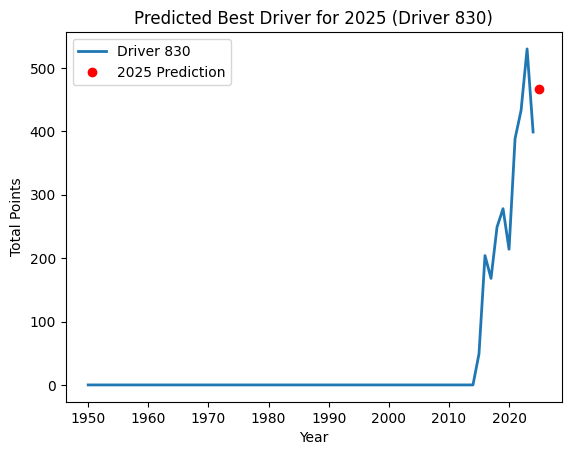

In [16]:

best_driver_index = np.argmax(predicted_points)  # Index of max predicted points
best_driver_2025 = driver_data.columns[best_driver_index]  # Get driverId


plt.plot(driver_data.index, driver_data[best_driver_2025], label=f"Driver {best_driver_2025}", linewidth=2)
plt.plot(driver_data.index[-1] + 1, predicted_points[best_driver_index], 'ro', label='2025 Prediction')

plt.xlabel("Year")
plt.ylabel("Total Points")
plt.title(f"Predicted Best Driver for 2025 (Driver {best_driver_2025})")
plt.legend()
plt.show()


In [34]:
# Save the LSTM model
model.save('lstm_time_series_model.h5')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

## 14.CHAMPIONSHIP RETENSION PROBABILITY

In [17]:
new_sequence = np.vstack([last_sequence[0][1:], predicted_scaled])
new_sequence = new_sequence.reshape((1, SEQ_LENGTH, X.shape[2]))

predicted_scaled_2025 = model.predict(new_sequence)
predicted_points_2025 = scaler.inverse_transform(predicted_scaled_2025)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [18]:
# Add predicted champions
historical_champions = driver_data.idxmax(axis=1).tolist()
driver_ids = driver_data.columns

champion_2024 = driver_ids[np.argmax(predicted_points)]
champion_2025 = driver_ids[np.argmax(predicted_points_2025)]

historical_champions.append(champion_2024)
historical_champions.append(champion_2025)

In [19]:
def calculate_back_to_back_probability(champions):
    back_to_back_count = 0
    for i in range(1, len(champions)):
        if champions[i] == champions[i - 1]:
            back_to_back_count += 1
    probability = back_to_back_count / (len(champions) - 1)
    return probability

prob = calculate_back_to_back_probability(historical_champions)

In [20]:
print(f"Predicted Drivers' Champion for 2024: Driver {champion_2024}")
print(f"Predicted Drivers' Champion for 2025: Driver {champion_2025}")

if champion_2024 == champion_2025:
    print(f"The 2024 champion ({champion_2024}) is predicted to retain the title in 2025.")
else:
    print(f"A new champion is predicted for 2025: Driver {champion_2025}.")

print(f"\nHistorical Probability of Back-to-Back Championships: {prob:.2%}")

Predicted Drivers' Champion for 2024: Driver 830
Predicted Drivers' Champion for 2025: Driver 830
The 2024 champion (830) is predicted to retain the title in 2025.

Historical Probability of Back-to-Back Championships: 35.53%


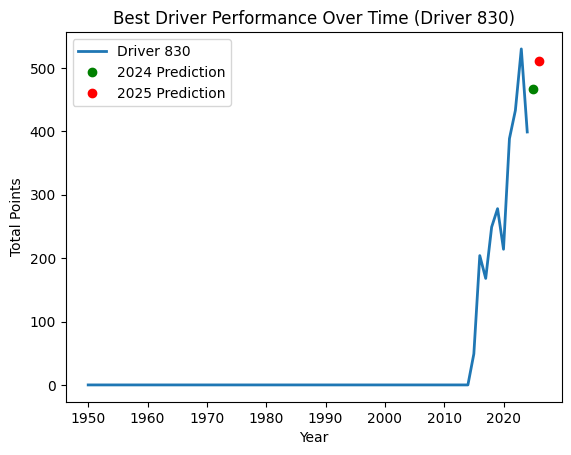

In [21]:
best_driver_index = np.argmax(predicted_points_2025)
best_driver = driver_ids[best_driver_index]

plt.plot(driver_data.index, driver_data[best_driver], label=f"Driver {best_driver}", linewidth=2)
plt.plot(driver_data.index[-1] + 1, predicted_points[best_driver_index], 'go', label='2024 Prediction')
plt.plot(driver_data.index[-1] + 2, predicted_points_2025[best_driver_index], 'ro', label='2025 Prediction')

plt.xlabel("Year")
plt.ylabel("Total Points")
plt.title(f"Best Driver Performance Over Time (Driver {best_driver})")
plt.legend()
plt.show()

# 4. MARKOV CHAIN MODEL

## 16. BONUS CHALLENGE

In [27]:
driver_team = results_data.merge(constructors_data[['constructorId', 'name']], on='constructorId')
driver_team = driver_team[['driverId', 'raceId', 'name']]
driver_team = driver_team.merge(race_data[['raceId', 'year']], on='raceId')
driver_team = driver_team.sort_values(by=['driverId', 'year'])

In [32]:
transition_counts = {}
"""
groups each driver team history and lists the teams they have raced for.
It then tracks how drivers move from one team to another by counting each from team to team transitions
"""
for driver_id, group in driver_team.groupby('driverId'):
    teams = group['name'].tolist()
    for i in range(len(teams) - 1):
        pair = (teams[i], teams[i + 1])
        if pair not in transition_counts:
            transition_counts[pair] = 0
        transition_counts[pair] += 1

transition_df = pd.DataFrame([{'from': k[0], 'to': k[1], 'count': v} for k, v in transition_counts.items()])
transition_matrix = transition_df.pivot_table(index='from', columns='to', values='count', fill_value=0)
transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

In [29]:
def predict_next_team(current_team, transition_matrix):
    if current_team in transition_matrix.index:
        return transition_matrix.loc[current_team].idxmax()
    else:
        return "Unknown"

In [30]:
example_driver_id = 1  # Change as needed
last_team = driver_team[driver_team['driverId'] == example_driver_id].sort_values(by='year').iloc[-1]['name']
predicted_team = predict_next_team(last_team, transition_matrix)

print(f"Predicted next team for driver {example_driver_id}: {predicted_team}")

Predicted next team for driver 1: Mercedes
